## Using XGBoost - regression model

uses code from https://github.com/jomartla/medium_articles/blob/main/XGBoost/XGBoost.ipynb

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

In [2]:
# read the data
data = pd.read_csv('income_data_categ.csv')

In [3]:
# one hot encoding for the categorical variable (Residence)
data = pd.get_dummies(data, columns=['Residence'], drop_first=False)
data.head()

,Income,Age,Education,Smoker,Residence_East,Residence_North,Residence_South,Residence_West
0,113,69,12,1,0,0,1,0
1,91,52,18,0,0,0,0,1
2,121,65,14,0,0,0,0,1
3,81,58,12,0,0,0,0,1
4,68,31,16,1,0,0,0,1


In [4]:
# define X and y
X = data.drop('Income', axis=1)
y = data['Income']

# split the data into a training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define baseline model (without tuning any parameter)
model = xgb.XGBRegressor(random_state=42)
results = cross_validate(model, X_train, y_train, cv=5,
                         return_train_score=True, scoring="neg_mean_absolute_error")
results

{'fit_time': array([0.42617035, 0.06273198, 0.06062889, 0.0683763 , 0.06642962]),
 'score_time': array([0.        , 0.00389767, 0.        , 0.01006866, 0.00764823]),
 'test_score': array([-9.0063863 , -8.60245635, -9.20960182, -8.87166853, -9.394629  ]),
 'train_score': array([-3.45891324, -3.58391548, -3.47600705, -3.51591392, -3.45065238])}

In [6]:
# Getting the mean score of the 5 folds (either from train and test)
baseline_mean_train_score = np.multiply(results["train_score"], -1).mean()
baseline_mean_test_score = np.multiply(results["test_score"], -1).mean()
baseline_mean_train_score, baseline_mean_test_score

(3.4970804135004676, 9.016948399543761)

### First GridSearchCV

In [7]:
# Defining the parameters grid
parameters_grid = {'max_depth': [4, 5, 6], 
                   'learning_rate': [0.1, 0.2, 0.3],
                   'n_estimators': [50, 100, 150], 
                   'gamma': [0, 20], 
                   'subsample': [0.8, 1], 
                   'colsample_bytree': [0.8, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}

xgboost = xgb.XGBRegressor()

xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="neg_mean_absolute_error", return_train_score=True)
xgb_gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.8, 1], 'eval_metric': ['mae'],
                         'gamma': [0, 20], 'lambda': [0, 0.1, 1],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1], 'tree_method': ['hist']},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [8]:
cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_mae"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_mean_mae"])],
                       axis=1)
cv_results.sort_values(by="test_mean_mae", ascending=False)

,colsample_bytree,eval_metric,gamma,lambda,learning_rate,max_depth,n_estimators,subsample,tree_method,test_mean_mae,train_mean_mae
289,0.8,mae,20,1.0,0.2,4,50,1.0,hist,-7.360468,-6.466420
293,0.8,mae,20,1.0,0.2,4,150,1.0,hist,-7.360499,-6.466471
291,0.8,mae,20,1.0,0.2,4,100,1.0,hist,-7.360499,-6.466471
271,0.8,mae,20,1.0,0.1,4,50,1.0,hist,-7.363924,-6.534468
270,0.8,mae,20,1.0,0.1,4,50,0.8,hist,-7.375874,-6.554329
...,...,...,...,...,...,...,...,...,...,...,...
377,1.0,mae,0,0.0,0.3,6,150,1.0,hist,-9.467322,-2.640565
52,0.8,mae,0,0.0,0.3,6,150,0.8,hist,-9.474677,-3.587451
484,1.0,mae,0,1.0,0.3,6,150,0.8,hist,-9.482357,-3.265369
376,1.0,mae,0,0.0,0.3,6,150,0.8,hist,-9.682068,-3.092249


In [9]:
best_score = abs(cv_results.sort_values(by="test_mean_mae", ascending=False).iloc[0]["test_mean_mae"])

In [10]:
best_score

7.360468395551045

### Individual parameters

In [11]:
def get_cross_validate_scores(df_scores, feature, value, model, X_train, y_train, best_score, metric="neg_mean_absolute_error"):
    # Train the model with cross_validation and get the results
    results = cross_validate(model, X_train, y_train, cv=5,
                             return_train_score=True, scoring=metric)
    # Calculate the metrics
    mean_train_score = np.multiply(results["train_score"], -1).mean()
    mean_test_score = np.multiply(results["test_score"], -1).mean()
    
    # Create different rows to add to the scores.
    print(f"{feature}: {value} - Train Score: {mean_train_score} - Test Score: {mean_test_score}")
    
    train_row_df = pd.DataFrame.from_dict({"value": value,
                                           "train_test": "train",
                                           "score": (results["train_score"] * -1)})
    test_row_df = pd.DataFrame.from_dict({"value": value,
                                          "train_test": "test",
                                          "score": (results["test_score"] * -1)})
    baseline_row_df = pd.DataFrame.from_dict({"value": value,
                                              "train_test": "best_score",
                                              "score": [best_score]})
    # Add the scores obtained to the main dataframe
    df_scores = pd.concat([df_scores, train_row_df, test_row_df, baseline_row_df])
    
    return df_scores

In [12]:
def plot_parameter_scores(feature, df_scores):
    # Create the plot
    parameter_plot = sns.relplot(data=df_scores, x="value", y="score", kind="line", hue="train_test")
    
    # Set the titles and axis labels
    parameter_plot.set_titles(f"{feature} Parameter")
    parameter_plot.set_ylabels("MAE", clear_inner=False)
    parameter_plot.set_xlabels(f"{feature}", clear_inner=False)

In [13]:
# Defining the best parameters found with GridSearchCV
gscv_best_params = {"colsample_bytree": 0.8, "eval_metric": "mae",
                    "gamma": 0, "lambda": 1, "learning_rate": 0.1, 
                    "max_depth": 4, "n_estimators": 150, "subsample": 1.0, 
                    "random_state":42}

In [14]:
# Defining, for each parameter, a name without special characters and an array with the values to test
main_parameters_dict = {"n_estimators": ["N Estimators", [125, 150, 175, 200, 225]]}

N Estimators

N Estimators: 125 - Train Score: 6.153695997397105 - Test Score: 7.489811549186707
N Estimators: 150 - Train Score: 6.054937201738357 - Test Score: 7.539031888643902
N Estimators: 175 - Train Score: 5.970412544012069 - Test Score: 7.595470552444459
N Estimators: 200 - Train Score: 5.8746756621201826 - Test Score: 7.652652045885722
N Estimators: 225 - Train Score: 5.792005928357442 - Test Score: 7.697568508783976




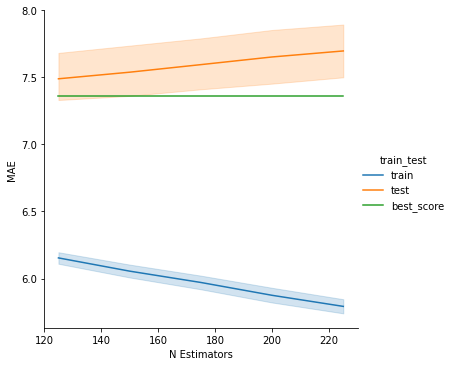

In [15]:
# Iterating over the parameter dictionary
for parameter, arguments in main_parameters_dict.items():
    # Create an empty dataframe for the scores
    df_scores = pd.DataFrame(columns=["value", "train_test", "score"])
    
    print(f"{arguments[0]}\n")
    
    # Depending on the parameter, different models are built
    for parameter_value in arguments[1]:
        # Getting the best parameters found with GridSearchCV
        params_to_use = gscv_best_params.copy()
        # Adding the individual value of the parameter that we want to test
        params_to_use[parameter] = parameter_value
        
        # Create the XGBoost model with the parameters
        model = xgb.XGBRegressor().set_params(**params_to_use)
        
        # Adding the cross validate scores of a parameter value to the df_scores dataframe
        df_scores = get_cross_validate_scores(df_scores=df_scores, feature=arguments[0], value=parameter_value, model=model,
                                              X_train=X_train, y_train=y_train, best_score=best_score)
    
    # Plot the parameter scores
    plot_parameter_scores(arguments[0], df_scores)
    
    print("\n")

### Second round

In [16]:
# Using the information gathered before to define the parameters grid
parameters_grid = {'max_depth': [4, 5], 
                   'learning_rate': [0.05, 0.1, 0.15],
                   'n_estimators': [150, 300, 450], 
                   'gamma': [0, 20], 
                   'subsample': [0.7, 1], 
                   'colsample_bytree': [0.7, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}

xgboost = xgb.XGBRegressor()

xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="neg_mean_absolute_error", return_train_score=True)
xgb_gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.7, 1], 'eval_metric': ['mae'],
                         'gamma': [0, 20], 'lambda': [0, 0.1, 1],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [4, 5], 'n_estimators': [150, 300, 450],
                         'subsample': [0.7, 1], 'tree_method': ['hist']},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [17]:
cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_mae"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_mean_mae"])],
                       axis=1)
cv_results.sort_values(by="test_mean_mae", ascending=False)

,colsample_bytree,eval_metric,gamma,lambda,learning_rate,max_depth,n_estimators,subsample,tree_method,test_mean_mae,train_mean_mae
180,0.7,mae,20,1.0,0.05,4,150,0.7,hist,-7.356008,-6.509558
181,0.7,mae,20,1.0,0.05,4,150,1.0,hist,-7.358953,-6.524331
183,0.7,mae,20,1.0,0.05,4,300,1.0,hist,-7.360213,-6.526233
185,0.7,mae,20,1.0,0.05,4,450,1.0,hist,-7.360213,-6.526233
197,0.7,mae,20,1.0,0.10,4,450,1.0,hist,-7.362157,-6.542056
...,...,...,...,...,...,...,...,...,...,...,...
287,1.0,mae,0,0.1,0.15,5,450,1.0,hist,-9.221943,-3.148397
248,1.0,mae,0,0.0,0.15,5,300,0.7,hist,-9.228532,-3.855557
251,1.0,mae,0,0.0,0.15,5,450,1.0,hist,-9.340539,-3.116982
286,1.0,mae,0,0.1,0.15,5,450,0.7,hist,-9.414376,-3.564240


### Validate the model with the test set

In [18]:
# Calculate Mean Absolute Error (MAE) for the Test Set
test_mae = mean_absolute_error(y_true=y_test, y_pred=xgb_gscv.best_estimator_.predict(X_test))
test_mae

7.742575950622559